In [1]:
from tsvd import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import scipy.misc
from tecpsgd import *
from olstec import *
from stc import *
from skimage.measure import compare_ssim

# def main():

## Read in video data and form tensor
import os
path = '/Users/kgilman/Desktop/datasets/dataMERL/'
files = []
for i in sorted(os.listdir(path)):
    if os.path.isfile(os.path.join(path,i)) and 'frame' in i:
        files.append(i)

num_frames = len(files)
nx,ny = mpimg.imread(path + files[0]).shape
L = np.zeros((int(nx), num_frames, int(ny)))

for i in range(0,num_frames):
    im = mpimg.imread(path + files[i])
    im = im / np.max(im)
    L[:,i,:] = im

    
# Lmean = np.mean(L)
Lmean = 0
L -= Lmean
L = Tensor(L)
n1,n2,n3 = L.shape()

np.random.seed(0)
rho = 0.8 #% missing entries
mask = np.random.rand(n1, n2, n3)
mask[mask > rho] = 1
mask[mask <= rho] = 0
mask = mask.astype(int)

Y = Tensor(L.array() * mask)

Lfrob = tfrobnorm(L)

print(Y.shape())

plt.imshow(L.array()[:,35,:],cmap='gray')
name = 'original-' + str(int(rho*100)) + '%'+'.eps'
plt.savefig(name)
plt.show()

plt.imshow(Y.array()[:,35,:],cmap='gray')
name = 'observed-' + str(int(rho*100)) + '%'+'.eps'
plt.savefig(name)
plt.show()


(192, 38, 256)


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

(192, 256)


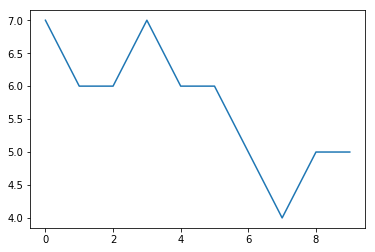

In [2]:
frame = L.array()[:,35,:]
print(frame.shape)
blk_size = 25
ranks = []
for k in range(0,int(np.floor(n3/blk_size))):
    blk = frame[:,blk_size * k: blk_size * k + blk_size]
    U,S,V = np.linalg.svd(blk,full_matrices=False)
    pwr_perc = np.cumsum(S / np.sum(S))
#     print(pwr_perc)
    idx = np.where(pwr_perc >= 0.8)[0]
#     print(idx)
    ranks.append(idx[0] + 1)
    
plt.plot(ranks)
plt.show()


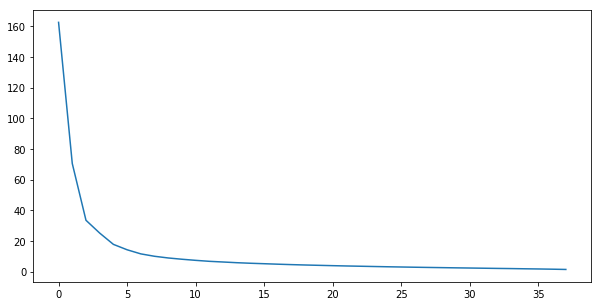

Number of LR t-SVD Approx Components: 9.000


In [3]:
U,S,V = tsvd(L,full=False)

plt.figure(figsize=(10,5))
plt.plot(np.diag(S.array()[:,:,0]))
plt.xticks(np.arange(0, min(n1,n2), step=5))
plt.rcParams.update({'font.size': 15})
plt.show()

s = np.diag(S.array()[:,:,0])
power80 = 0.75*np.sum(s)

cum_sum = 0
k = 0
for i in range(0,len(s)):
    cum_sum += s[i]
    k += 1
    if(cum_sum > power80):
        break

print('Number of LR t-SVD Approx Components: {:.3f}'.format(k))

### STC

In [4]:
## Sequential Tensor Completion

Tensor_Y = np.transpose(L.array(),[0,2,1])
Mask_Y = np.transpose(mask,[0,2,1])
numcycles = 1
outer = 3
r1 = 50
r2 = 50
r3 = 2
fun = lambda Lhat,idx: [0, tfrobnorm_array(Lhat[:,:,idx] - Tensor_Y[:,:,idx]) / tfrobnorm_array(Tensor_Y[:,:,idx])]
Lhat, stats, tElapsed = stc(Tensor_Y,Mask_Y,r1,r2,r3,outer,numcycles,fun=fun,verbose=True)

Lhat = np.transpose(Lhat,[0,2,1])

nrmse_stc = tfrobnorm(Tensor(Lhat) - L) / Lfrob

print('STC Time: {:4f}'.format(tElapsed))
print('NRMSE STC: {:6f}'.format(nrmse_stc))

Outer[0], Inner[0]: NRMSE: 0.77164270 
Outer[0], Inner[10]: NRMSE: 0.35998115 
Outer[0], Inner[20]: NRMSE: 0.39438853 
Outer[0], Inner[30]: NRMSE: 0.31793697 
Outer[1], Inner[0]: NRMSE: 0.35358746 
Outer[1], Inner[10]: NRMSE: 0.29769103 
Outer[1], Inner[20]: NRMSE: 0.36624544 
Outer[1], Inner[30]: NRMSE: 0.30430119 
Outer[2], Inner[0]: NRMSE: 0.34825031 
Outer[2], Inner[10]: NRMSE: 0.29267094 
Outer[2], Inner[20]: NRMSE: 0.36153494 
Outer[2], Inner[30]: NRMSE: 0.30234619 
STC Time: 34.815444
NRMSE STC: 0.308764


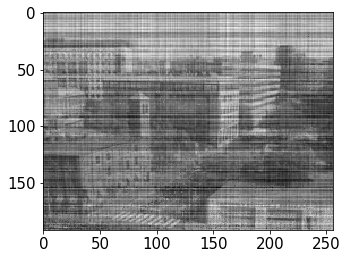

In [5]:
plt.imshow(Lhat[:,35,:],cmap='gray')
name = 'merl_stc-' + str(int(rho*100)) + '%'+'.eps'
plt.savefig(name)
plt.show()

In [6]:
# from skimage.metrics import structural_similarity as ssim
# ssim_noise = ssim(L[:,35,:], Lhat[:,35,:],
#                   data_range=np.max(Lhat[:,35,:]) - np.min(Lhat[:,35,:]))

(score, diff) = compare_ssim(L.array()[:,35,:], Lhat[:,35,:], full=True)
print('STC SSIM: {:.5f}'.format(score))

STC SSIM: 0.48684


/Users/kgilman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


In [2]:
from cp_wopt import *

max_iter = 50
tol = 1e-7
rank = 30
fun = lambda Xhat: [0,frobnorm(Xhat - L.array()) / Lfrob]

Lhat_cpwopt, stats, tElapsed = cp_wopt(Y.array(),mask,rank=rank,
                                       max_iter=max_iter,tol=tol,fun=fun, verbose=True, printEvery = 1)

Iter[0]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[1]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[2]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[3]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[4]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[5]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[6]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[7]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[8]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[9]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[10]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[11]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[12]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[13]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[14]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[15]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[16]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[17]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[18]: Cost fxn: 0.000, NRMSE: 1190.031992 
Iter[19]: Cost fxn: 0.000, NRMSE: 1190.031992 


KeyboardInterrupt: 

In [ ]:
plt.imshow(Lhat_cpwopt[:,35,:],cmap='gray')
name = 'merl_tenals-' + str(int(rho*100)) + '%'+'.eps'
# plt.savefig(name)
plt.show()

### TenALS

In [46]:
from tenals import *

max_iter = 100
tol = 1e-7
rank = 100
fun = lambda Xhat: [0,frobnorm_array(Xhat - L.array()) / Lfrob]

Lhat_tenals,V1,V2,V3,stats = TenALS(Y.array(),mask,r=rank,max_iter=max_iter,tol=tol,init='rptm',ninit = 50, fun = fun, verbose = True)

nrmse_tenals = tfrobnorm(Tensor(Lhat_tenals) - L) / Lfrob
print('NRMSE TenALS: {:6f}'.format(nrmse_tenals))

KeyboardInterrupt: 

In [ ]:
plt.imshow(Lhat_tenals[:,35,:],cmap='gray')
name = 'merl_tenals-' + str(int(rho*100)) + '%'+'.eps'
# plt.savefig(name)
plt.show()

### OLSTEC

OLSTEC Time: 71.366871
NRMSE OLSTEC: 0.102485


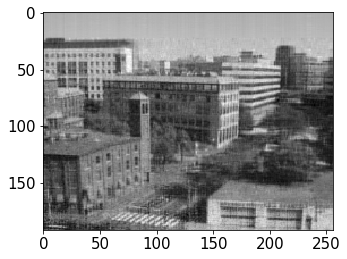

OLSTEC SSIM: 0.87518


/Users/kgilman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


In [7]:
## OLSTEC

Tensor_Y_Noiseless = np.transpose(L.array(),[0,2,1])
rank = 100
OmegaTensor = np.transpose(mask,[0,2,1])
tensor_dims = [n1,n3,n2]
maxepochs = 2
tolcost = 1e-14
permute_on = False

options = {
    'maxepochs': maxepochs,
    'tolcost': tolcost,
    'lam': 0.7,
    'mu': 0.1,
    'permute_on':  permute_on,
    'store_subinfo': True,
    'store_matrix': False,
    'verbose': False,
    'tw_flag': None,
    'tw_len': None
}

Xinit = {
    'A': np.random.randn(tensor_dims[0], rank),
    'B': np.random.randn(tensor_dims[1], rank),
    'C': np.random.randn(tensor_dims[2], rank)
}

Xsol_olstec, Y_hat_olstec, info_olstec, sub_infos_olstec = OLSTEC(Tensor_Y_Noiseless, OmegaTensor, None, tensor_dims, rank,
                                                          Xinit, options)

A_t0 = Xsol_olstec['A']
B_t0 = Xsol_olstec['B']
C_t0 = Xsol_olstec['C']

# Y_hat_olstec = np.zeros(Tensor_Y_Noiseless.shape)
# for f in range(0,n2):
#     gamma = C_t0[f,:].T
#     Y_hat_olstec[:,:,f] = A_t0 @ np.diag(gamma) @ B_t0.T
    
Y_hat_olstec = np.transpose(Y_hat_olstec,[0,2,1])

nrmse_olstec = tfrobnorm(Tensor(Y_hat_olstec) - L) / Lfrob
tElapsed_olstec = np.sum(sub_infos_olstec['times'])

print('OLSTEC Time: {:4f}'.format(tElapsed_olstec))
print('NRMSE OLSTEC: {:6f}'.format(nrmse_olstec))

plt.imshow(Y_hat_olstec[:,35,:],cmap='gray')
name = 'merl_olstec-' + str(int(rho*100)) + '%'+'.eps'
plt.savefig(name)
plt.show()

(score, diff) = compare_ssim(L.array()[:,35,:], Y_hat_olstec[:,35,:], full=True)
print('OLSTEC SSIM: {:.5f}'.format(score))

### TeCPSGD

TeCPSGD Time: 3.306439
NRMSE TeCPSGD: 0.152730


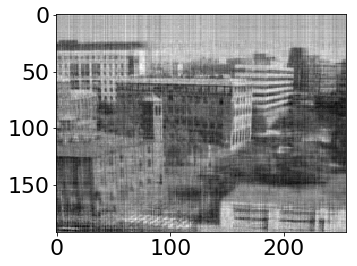

TeCPSGD SSIM: 0.75436


/Users/kgilman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


In [35]:
## TeCPSGD
from tecpsgd import *
Tensor_Y_Noiseless = np.transpose(L.array(),[0,2,1])
rank = 100
OmegaTensor = np.transpose(mask,[0,2,1])
tensor_dims = [n1,n3,n2]
maxepochs = 2
tolcost = 1e-14
permute_on = False

options = {
    'maxepochs': maxepochs,
    'tolcost': tolcost,
    'lam': 0.05,
    'stepsize': 10,
#     'mu': 0.1,
    'permute_on':  permute_on,
    'store_subinfo': True,
    'store_matrix': False,
    'verbose': False
}

Xinit = {
    'A': np.random.randn(tensor_dims[0], rank),
    'B': np.random.randn(tensor_dims[1], rank),
    'C': np.random.randn(tensor_dims[2], rank)
}

Xsol_TeCPSGD, Y_hat_tecpsgd, info_TeCPSGD, sub_infos_TeCPSGD = TeCPSGD(Tensor_Y_Noiseless, OmegaTensor, None, tensor_dims, rank,
                                                          Xinit, options)

A_t0 = Xsol_TeCPSGD['A']
B_t0 = Xsol_TeCPSGD['B']
C_t0 = Xsol_TeCPSGD['C']

# Y_hat_tecpsgd = np.zeros(Tensor_Y_Noiseless.shape)
# for f in range(0,n2):
#     gamma = C_t0[f,:].T
#     Y_hat_tecpsgd[:,:, f] = A_t0 @ np.diag(gamma) @ B_t0.T
    
Y_hat_tecpsgd = np.transpose(Y_hat_tecpsgd,[0,2,1])

nrmse_tecpsgd = tfrobnorm(Tensor(Y_hat_tecpsgd) - L) / Lfrob
tElapsed_tecpsgd = np.sum(sub_infos_TeCPSGD['times'])

print('TeCPSGD Time: {:4f}'.format(tElapsed_tecpsgd))
print('NRMSE TeCPSGD: {:6f}'.format(nrmse_tecpsgd))
plt.imshow(Y_hat_tecpsgd[:,35,:],cmap='gray')
name = 'merl_tecpsgd-' + str(int(rho*100)) + '%'+'.eps'
plt.savefig(name)
plt.show()

(score, diff) = compare_ssim(L.array()[:,35,:], Y_hat_tecpsgd[:,35,:], full=True)
print('TeCPSGD SSIM: {:.5f}'.format(score))

### TNN-ADMM

TNN Time: 22.877713
TNN NRMSE: 0.072715


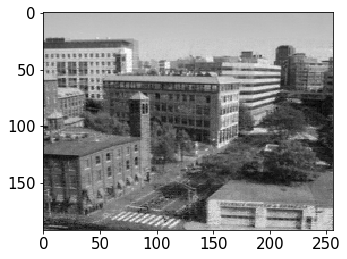

TNN-ADMM SSIM: 0.92131


/Users/kgilman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()


In [11]:
# ## TNN-ADMM
fun = lambda X: [0,tfrobnorm(X - L) / Lfrob]
# fun = lambda X: [0,0]
Y_hat_tnn,stats_tnn,tElapsed_tnn = lrtc(Y,mask,niter = 75,fun=fun,verbose=False)
# Y_hat_tnn,stats_tnn,tElapsed_tnn = lrtc(Tensor(np.transpose(Y.array(),[0,2,1])),np.transpose(mask,[0,2,1]),niter = 75,fun=fun,verbose=False)

tnn_nrmse = tfrobnorm(Y_hat_tnn - L) / Lfrob
print('TNN Time: {:4f}'.format(tElapsed_tnn))
print('TNN NRMSE: {:4f}'.format(tnn_nrmse))

plt.imshow(Y_hat_tnn.array()[:,35,:],cmap='gray')
name = 'merl_tnn-' + str(int(rho*100)) + '%'+'.eps'
plt.savefig(name)
plt.show()

(score, diff) = compare_ssim(L.array()[:,35,:], Y_hat_tnn.array()[:,35,:], full=True)
print('TNN-ADMM SSIM: {:.5f}'.format(score))

### TCTF

TCTF Time: 20.507129
TCTF NRMSE: 0.165805


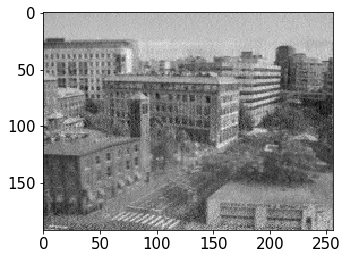

TCTF SSIM: 0.71759


/Users/kgilman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()


In [12]:
## TCTF
rank = 2
fun = lambda X,Z: [0, tfrobnorm(X*Z - L) / Lfrob]
Xtctf,Ztctf, stats_tctf, tElapsed_tctf = tctf(Y,mask,rank,niter = 75,fun=fun,verbose=False)
Y_hat_tctf = Xtctf * Ztctf

tctf_nrmse = tfrobnorm(Y_hat_tctf - L) / Lfrob
print('TCTF Time: {:4f}'.format(tElapsed_tctf))
print('TCTF NRMSE: {:4f}'.format(tctf_nrmse))

plt.imshow(Y_hat_tctf.array()[:,35,:],cmap='gray')
name = 'merl_tctf-' + str(int(rho*100)) + '%'+'.eps'
plt.savefig(name)
plt.show()

(score, diff) = compare_ssim(L.array()[:,35,:], Y_hat_tctf.array()[:,35,:], full=True)
print('TCTF SSIM: {:.5f}'.format(score))

### TOUCAN

TOUCAN Time: 3.869645
TOUCAN NRMSE: 0.174288


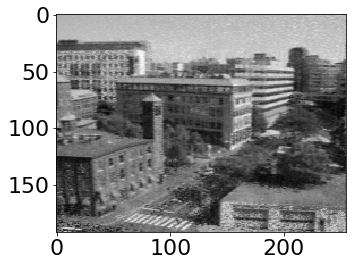

TOUCAN SSIM: 0.83720


/Users/kgilman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


In [23]:
## TOUCAN
rank = 1
# fun = lambda X: [0, tfrobnorm(X - L) / Lfrob]
fun = lambda X,k: [0, tfrobnorm_array(X - L.array()[:,k,:]) / tfrobnorm_array(L.array()[:,k,:])]
Y_hat_toucan, U, w, stats_toucan, tElapsed_toucan = toucan(Y,mask,rank,tube=False,outer=2,mode='online',fun=fun,cgtol=1e-6,
                                                     randomOrder=False,verbose=False)

toucan_nrmse = tfrobnorm(Y_hat_toucan - L) / Lfrob
print('TOUCAN Time: {:4f}'.format(tElapsed_toucan))
print('TOUCAN NRMSE: {:4f}'.format(toucan_nrmse))

plt.imshow(Y_hat_toucan.array()[:,35,:],cmap='gray')
name = 'merl_toucan-' + str(int(rho*100)) + '%'+'.eps'
plt.savefig(name)
plt.show()

(score, diff) = compare_ssim(L.array()[:,35,:], Y_hat_toucan.array()[:,35,:], full=True)
print('TOUCAN SSIM: {:.5f}'.format(score))

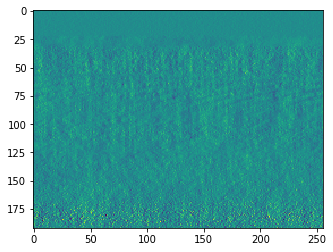

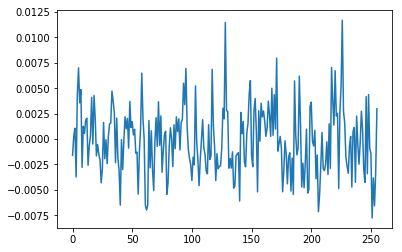

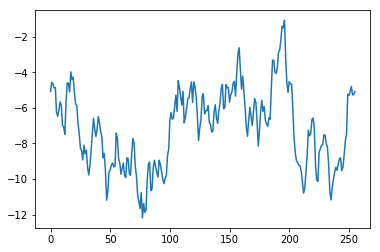

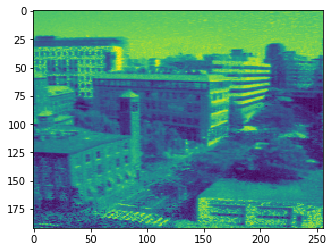

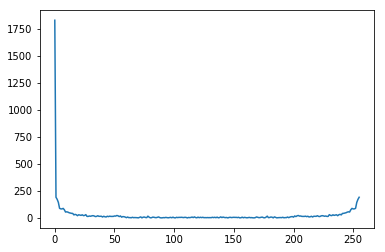

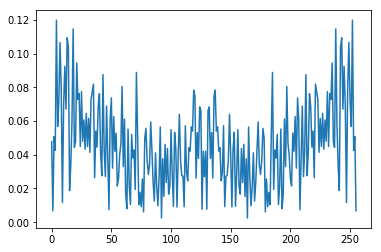

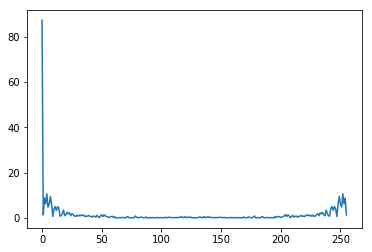

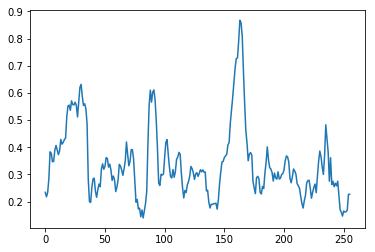

In [32]:
plt.imshow(U.array().squeeze())
plt.show()

U_row = U.array()[100,0,:]
plt.plot(U_row)
plt.show()

plt.plot(w.array()[0,0,:])
plt.show()

rec = (U * w).array().squeeze()

plt.imshow(rec)
plt.show()

w_fft = np.fft.fft(w.array()[0,0,:])
plt.plot(np.abs(w_fft))
plt.show()

U_row_fft = np.fft.fft(U.array()[100,0,:])
plt.plot(np.abs(U_row_fft))
plt.show()

mult = U_row_fft * w_fft
plt.plot(np.abs(mult))
plt.show()

im_row_reconst = np.real(np.fft.ifft(mult))
plt.plot(im_row_reconst)
plt.show()



In [15]:
## Matrix Completion Algorithms

Lm = lr_flatten(L.array())
Ym = lr_flatten(Y.array())
mask_m = lr_flatten(mask)

### MatComp

TOUCAN Time: 13.962412
TOUCAN NRMSE: 0.138973


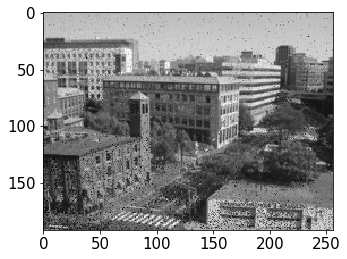

MatComp SSIM: 0.79330


/Users/kgilman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  from ipykernel import kernelapp as app


In [16]:
## MatComp

fun = lambda X: [0, np.linalg.norm(X - Lm,'fro') / np.linalg.norm(Lm,'fro')]
Ym_hat, stats_matcomp, tElapsed_matcomp = lrmc(Ym,mask_m,niter=100,fun=fun,verbose=False)

matcomp_nrmse = np.linalg.norm(Ym_hat - Lm,'fro') / np.linalg.norm(Lm,'fro')
print('TOUCAN Time: {:4f}'.format(tElapsed_matcomp))
print('TOUCAN NRMSE: {:4f}'.format(matcomp_nrmse))

plt.imshow(np.reshape(Ym_hat[:,35],(int(ny),int(nx))).T,cmap='gray')
name = 'merl_matcomp-' + str(int(rho*100)) + '%'+'.eps'
plt.savefig(name)
plt.show()

(score, diff) = compare_ssim(Lm[:,35], Ym_hat[:,35], full=True)
print('MatComp SSIM: {:.5f}'.format(score))

### GROUSE

GROUSE Time: 0.066787
GROUSE NRMSE: 0.224471


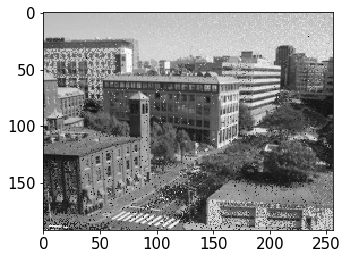

GROUSE SSIM: 0.78225


/Users/kgilman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()


In [18]:
## GROUSE
rank = 1
# fun = lambda X: [0, np.linalg.norm(X - Lm, 'fro') / np.linalg.norm(Lm, 'fro')]
fun = lambda X,idx: [0, np.linalg.norm(X - Lm[:,idx]) / np.linalg.norm(Lm[:,idx])]
Ym_hat_grouse, stats_grouse, tElapsed_grouse = grouse(Ym, mask_m, rank,outer=3,mode="online",fun=fun,randomOrder=False,
                                                      verbose=False)
grouse_nrmse = np.linalg.norm(Ym_hat_grouse - Lm,'fro') / np.linalg.norm(Lm,'fro')
print('GROUSE Time: {:4f}'.format(tElapsed_grouse))
print('GROUSE NRMSE: {:4f}'.format(grouse_nrmse))

plt.imshow(np.reshape(Ym_hat_grouse[:,35],(int(ny),int(nx))).T,cmap='gray')
name = 'merl_grouse-' + str(int(rho*100)) + '%'+'.eps'
plt.savefig(name)
plt.show()

(score, diff) = compare_ssim(Lm[:,35], Ym_hat_grouse[:,35], full=True)
print('GROUSE SSIM: {:.5f}'.format(score))

In [15]:
# ## Write out results

# for i in range(0,num_frames):
#     name = path + 'observed/frame_' + '%02d' % i + '.png'
#     scipy.misc.imsave(name, np.reshape(Ym[:, i], (int(ny), int(nx))).T)

# #     name = path + '/tnn_results/frame_' + '%02d' % i + '.png'
# #     scipy.misc.imsave(name, Y_hat_tnn.array()[:, i, :])

# #     name = path + '/tctf_results/frame_' + '%02d' % i + '.png'
# #     scipy.misc.imsave(name, Y_hat_tctf.array()[:, i, :])

#     name = path + '/toucan_results/frame_' + '%02d' % i + '.png'
#     scipy.misc.imsave(name, Y_hat_toucan.array()[:, i, :])

# #     name = path + 'matcomp_results/frame_' + '%02d' % i + '.png'
# #     scipy.misc.imsave(name, np.reshape(Ym_hat[:, i],(int(nx),int(ny))))

#     name = path + 'grouse_results/frame_' + '%02d' % i + '.png'
#     scipy.misc.imsave(name, np.reshape(Ym_hat_grouse[:, i], (int(ny), int(nx))).T)
    
#     name = path + 'tecpsgd_results/frame_' + '%02d' % i + '.png'
#     scipy.misc.imsave(name, np.reshape(Y_hat_tecpsgd[:, i], (int(nx), int(ny))))
    
#     name = path + 'olstec_results/frame_' + '%02d' % i + '.png'
#     scipy.misc.imsave(name, np.reshape(Y_hat_olstec[:, i], (int(nx), int(ny))))
    

In [16]:
# plt.figure(figsize=(10,5), tight_layout=True)
# plt.semilogy(np.cumsum(stats_toucan[:,-1]),stats_toucan[:,1], '#ff7f0e',
#          np.cumsum(stats_grouse[:, -1]), stats_grouse[:, 1], 'b',
#          np.cumsum(stats_tnn[:,-1]),stats_tnn[:,1], 'r',
#          np.cumsum(stats_tctf[:,-1]),stats_tctf[:,1], 'k',
#          np.cumsum(stats_matcomp[:,-1]),stats_matcomp[:,1],'g',
# )

# plt.legend(('TOUCAN', 'GROUSE', 'TNN-ADMM', 'TCTF', 'MatComp'),bbox_to_anchor=(1.1, 1 ))
# plt.xlabel('Time (s)')
# plt.ylabel('NRMSE')
# plt.grid()
# plt.rcParams.update({'font.size': 22})
# plt.savefig('merl_video_completion_nrmse_' + str(rho*100) + 'p.eps')
# plt.show()

/Users/kgilman/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


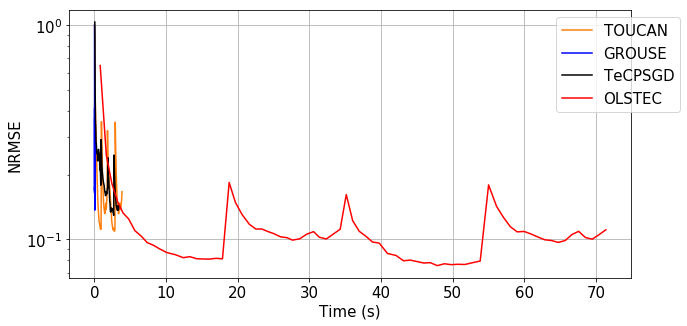

In [19]:
plt.figure(figsize=(10,5), tight_layout=True)
plt.semilogy(np.cumsum(stats_toucan[:,-1]),stats_toucan[:,1],'#ff7f0e',
         np.cumsum(stats_grouse[:, -1]), stats_grouse[:, 1],'b',
         np.cumsum(sub_infos_TeCPSGD['times'][1:]),sub_infos_TeCPSGD['err_residual'][1:],'k',
         np.cumsum(sub_infos_olstec['times'][1:]),sub_infos_olstec['err_residual'][1:],'r'
)

plt.legend(('TOUCAN', 'GROUSE', 'TeCPSGD', 'OLSTEC'),bbox_to_anchor=(1.1, 1 ))
plt.xlabel('Time (s)')
plt.ylabel('NRMSE')
plt.grid()
plt.rcParams.update({'font.size': 22})
# plt.savefig('merl_video_completion_nrmse_' + str(rho*100) + 'p.eps')
plt.show()

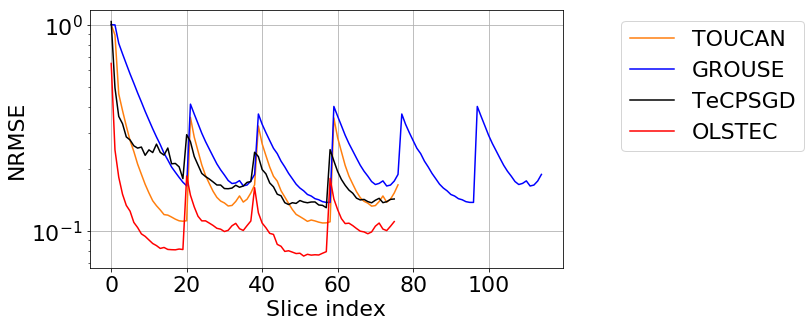

In [20]:
plt.figure(figsize=(12,5), tight_layout=True)
plt.semilogy(np.arange(0,len(stats_toucan)),stats_toucan[:,1],'#ff7f0e',
         np.arange(0,len(stats_grouse)), stats_grouse[:, 1],'b',
         np.arange(0,len(sub_infos_TeCPSGD['times'][1:])),sub_infos_TeCPSGD['err_residual'][1:],'k',
         np.arange(0,len(sub_infos_olstec['times'][1:])),sub_infos_olstec['err_residual'][1:],'r'
)

plt.legend(('TOUCAN', 'GROUSE', 'TeCPSGD', 'OLSTEC'),bbox_to_anchor=(1.1, 1 ))
plt.xlabel('Slice index')
plt.ylabel('NRMSE')
plt.grid()
plt.rcParams.update({'font.size': 22})
# plt.savefig('merl_video_completion_nrmse_' + str(rho*100) + 'p.eps')
plt.show()

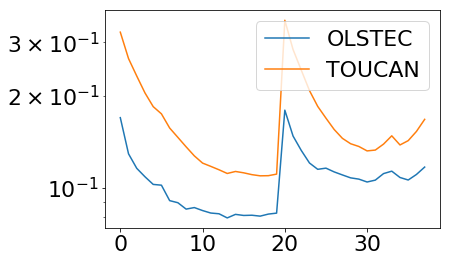

In [19]:
olstec_frame_err = []
toucan_frame_err = []

for i in range(0,n2):
    olstec_frame_err.append(np.linalg.norm(Y_hat_olstec[:,i,:].squeeze() - L.array()[:,i,:]) / np.linalg.norm(L.array()[:,i,:]))
    toucan_frame_err.append(np.linalg.norm(Y_hat_toucan.array()[:,i,:].squeeze() - L.array()[:,i,:]) / np.linalg.norm(L.array()[:,i,:]))

plt.semilogy(np.arange(0,len(olstec_frame_err)),olstec_frame_err,np.arange(0,len(toucan_frame_err)),toucan_frame_err)
plt.legend(['OLSTEC','TOUCAN'])
plt.show()